In [2]:
%pylab inline
#import matplotlib as plt
#import numpy as np
import pandas as pd
import uncertainties
from uncertainties import unumpy as unp
from uncertainties import ufloat

def gaussian(x, mu, sigma, B, A):
    return A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, B, A: A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)) + B,
                  p0=p0)

def lorentz(x, x_0, gamma, a, d):
    return a * 1/(1 + ((x - x_0)/gamma)**2) + d

def lorentzfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, x_0, gamma, a, d: a * 1/(1 + ((x - x_0)/gamma)**2) + d,p0=p0)

def line(x,a,b):
    return a * x + b

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)


def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2


def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x


def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

def LRmG(x: list , y: list, u: list) -> list:
    """Linear Regression, weighted.
    
    """
    try:
        u[0]
        if (len(x) != len(y)):
            raise LenError
        if (len(x) != len(u)):
            raise LenError
        x = array(x)
        y = array(y)
        u = array(u)
        g = []
        for i in range(len(y)):
            g.append(1 / u[i] ** 2)

        a = (sum(g * (x ** 2)) * sum(g * y) - sum(g * x) * sum(g * x * y)) / (
                    sum(g) * sum(g * (x ** 2)) - (sum(g * x) ** 2))

        b = (sum(g) * sum(g * x * y) - sum(g * x) * sum(g * y)) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2)

        ua = sqrt(sum(g * x ** 2) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        ub = sqrt(sum(g) / (sum(g) * sum(g * x ** 2) - sum(g * x) ** 2))

        return a, b, ua, ub

    except TypeError:
        return LRmG(x, y, ones(len(y)) * u)


Populating the interactive namespace from numpy and matplotlib


In [3]:
def analysis(filename,plots=False,save=False,values=False, printt=False,force_ori=(False,0),**kwargs):
    def linfitter(x,y):
        itera = 0
        start = 0
        stop = 0
        lastval = 0
        trigger = False
        for item in y:
            if (lastval-item) > 1:  # rampe primed
                trigger = True
            if trigger and item > -1 and start == 0: # startwert für sauberen fit
                start = itera
            if trigger and item > 1:  #  endwert sauberer fit
                stop = itera
                break
            itera += 1
            lastval = item
        return linfit_pm(x[start:stop],y[start:stop])


    def lorenzer(x,y):
        if force_ori[0]:
            if force_ori[1]==0:
                if plots:
                    print("0 deg")
                return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
            if force_ori[1]==90:
                if plots:
                    print("90 deg")
                return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))
        if abs(abs(y[0])+abs(max(y)))>abs(abs(y[0])-abs(min(y))):  # 0°-> peak über start
            if plots:
                print("0 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(max(y))],1e-5,max(y)-y[0],y[0]))
        if abs(y[0]+max(y))<abs(y[0]-min(y)):  # 90° -> peak unter start
            if plots:
                print("90 deg")
            return lorentzfit_pm(x,y,p0 = (x[list(y).index(min(y))],1e-5,min(y)-y[0],y[0]))


    # konstanten
    k = 3.363e-4
    gJ = 1.4838
    muB = 9.274009e-24
    hb = 1.0546e-34
    gamma_stat = 6.075938865802572e-07
    
    # daten einlesen, in arrays umwandeln
    df = pd.read_csv(filename)  # einlesen
    time = df.iloc[0:,0].to_numpy()  # zeit
    ch1 = df.iloc[0:,1].to_numpy()  # signal
    ch2 = df.iloc[0:,2].to_numpy()  # magnetfeld
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(time,ch1,label="Photomultiplier")
        plt.plot(time,ch2,label="Magnetfeld")
        #plt.plot(time_90,lorentz(time_90,*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Zeit $\left[s\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            
            plt.savefig(filename[-4]+"_raw"+".png")
        plt.show()
        
    # B(t) bestimmen
    lin_params ,lin_r_2 = linfitter(time,ch2) # linfit
    (a,b) = lin_params
    if printt:
        print("line params",a,b,"\n")
    B = (a*time+b)*k
    if printt:
        print("B",B,"\n")
    # fit B(t) signal
    lor_params,lor_r_2 = lorenzer(val(B),ch1)
    if printt:
        print("lor params",lor_params,"\n")
    x_0, gamma, a, d = lor_params
    
    if plots:
        #nice plot
        ### FigureSize

        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 7.5
        plt.rcParams["figure.figsize"] = fig_size

        ###   Errors / Fit / Plot

        plt.plot(val(B),ch1,label="Photomultiplier")
        #plt.plot(val(B),ch2_90,label="Magnetfeld")
        plt.plot(val(B),lorentz(val(B),*val(lor_params)),label="Lorentzfit")



        ###   Label / Title

        plt.ylabel(r'$U\,[\mathrm{V}]$', fontsize=13)
        plt.xlabel(r'Magnetfeld $\left[T\right]$', fontsize=13)
        plt.title(filename, fontsize=20)

        ###   Axes / Grid

        axes = plt.gca()  ##  Searches current Axes

        #axes.set_xlim([0,0.8])
        #axes.set_ylim([-1,110])

        #axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
        #axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

        axes.grid(which='major', linestyle='-', linewidth='1', color='black')
        axes.grid(which='minor', linestyle=':', color='gray')
        axes.minorticks_on()

        plt.legend()
        if save:
            plt.savefig(filename[:-4]+"_lorenz"+'.png')
        plt.show()
    
    gamma = ufloat(val(gamma),
                   np.sqrt(err(gamma)**2+gamma_stat**2)
                  )
    FWHM = 2*gamma
    if printt:
        print(FWHM)
    # tau berechnen
    tau = hb/(gJ*muB*FWHM)
    if values:
        return tau,[lin_params,lor_params]
    else: return tau

In [4]:
def T_p(x):   #Konstanten als Fehlerlos angenommen wie suggested in anleitung
    x = x + 273.15
    T_c = 1764
    p_c = 1.67 * 10**5
    Tr = 1-(x/T_c)
    a1 = -4.57618368
    a2 = -1.40726277
    a3 = 2.36263541
    a4 = -31.0889985
    a5 = 58.0183959
    a6 = -27.6304546
    p = (  (T_c/x) * (a1*Tr + a2*Tr**1.89 + a3*Tr**2 + a4*Tr**8 + a5*Tr**8.5 + a6*Tr**9)  )
    p2 = e**(p)*p_c*10**6
    return p2

In [5]:
temps=unp.uarray([20,12,6,-2,-17],0.5)
files = [["87.5_1_HM1508.csv","87.5_1_HM1508.csv"],["0_2_HM1508.csv","90_2_HM1508.csv"],
         ["0_3_HM1508.csv","90_3_HM1508.csv"],["0_4_HM1508.csv","90_4_HM1508.csv"],
         ["0_5_HM1508.csv","90_5_HM1508.csv"]]


In [6]:
abk_points=[[],[],[]]
for i in range(0,len(temps)):
    temp = temps[i]
    file_0,file_90 = files[i]
    abk_points[0].append(T_p(temp))
    #abk_points[0].append(T_p(temp))
    
    abk_points[1].append(analysis(file_0,plots=0,printt=0,force_ori=(1,0)))    
    abk_points[2].append(analysis(file_90,plots=0,printt=0,force_ori=(1,90)))

In [7]:
abk_points[1][0]=ufloat(1.265734819693841e-07,7.749890651139579e-10)

In [19]:

a,b,ua,ub=LRmG(val(abk_points[0][:-1]),val(abk_points[1][:-1]),err(abk_points[1][:-1]))
abk1_params = ufloat(b,ub),ufloat(a,ua)
a,b,ua,ub = LRmG(val(abk_points[0]),val(abk_points[2]),err(abk_points[2]))
abk2_params = ufloat(b,ub),ufloat(a,ua)

In [35]:
print("Abkühlung 1")
print("0° Params")
[print(item) for item in abk1_params]
print("90° Params")
[print(item) for item in abk2_params]

Abkühlung 1
0° Params
(2.4+/-1.4)e-11
(1.224+/-0.022)e-07
90° Params
(9.0+/-2.6)e-11
(1.222+/-0.020)e-07


[None, None]

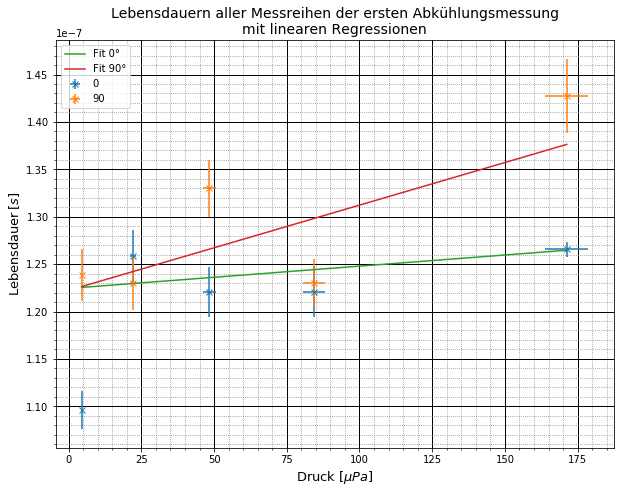

In [30]:

#nice plot
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot


plt.errorbar(x=val(abk_points[0]),y=val(abk_points[1]),yerr=err(abk_points[1]),xerr=err(abk_points[0]),fmt="x",label="0")
plt.errorbar(val(abk_points[0]),val(abk_points[2]),xerr=err(abk_points[0]),yerr=err(abk_points[2]),fmt="x",label="90")
plt.plot(val(abk_points[0]),line(val(abk_points[0]),*val(abk1_params)),label="Fit 0°")
plt.plot(val(abk_points[0]),line(val(abk_points[0]),*val(abk2_params)),label="Fit 90°")


###   Label / Title

plt.ylabel(r'Lebensdauer$\,\left[s\right]$', fontsize=13)
plt.xlabel(r'Druck $\left[µPa\right]$', fontsize=13)
plt.title("Lebensdauern aller Messreihen der ersten Abkühlungsmessung\nmit linearen Regressionen", fontsize=14)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,0.8])
#axes.set_ylim([-1,110])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()

plt.savefig("Abkühlung1_endergebnis"+'.png')
plt.show()